<a href="https://colab.research.google.com/github/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis/blob/master/LearningWithoutForgetting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis.git
%cd AudioClassificationWithDeepLearningAnalysis
!pwd

Cloning into 'AudioClassificationWithDeepLearningAnalysis'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 44 (delta 13), reused 28 (delta 5), pack-reused 0
Unpacking objects: 100% (44/44), done.
/content/AudioClassificationWithDeepLearningAnalysis
/content/AudioClassificationWithDeepLearningAnalysis


In [2]:
import numpy as np
import torch
import models
import copy
import torch.nn.functional as F

Adding google speech command dataset

In [3]:
import torchaudio

dataset = torchaudio.datasets.SPEECHCOMMANDS('./dataset/data/' , url = 'speech_commands_v0.02', folder_in_archive= 'SpeechCommands',  download = True)

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

split dataset and add to dataloder.

Use different transformation for it

In [4]:
labels = sorted(list(set(datapoint[2] for datapoint in dataset)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [8]:
import random
# random_targets = random.sample(labels, 3)
# print(f"Randomly selected tagets: {random_targets}")

random_targets = ['right', 'down', 'yes']
print(f"Randomly selected tagets: {random_targets}")

digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
labels = digits + random_targets
print(f"List of all target classes: {labels}"
)
def label_to_index(label):
    # Return the position of the word in labels
    return torch.tensor(labels.index(label))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

tensors = []
targets = []

#parameters for MFCC transformation
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

for waveform, sample_rate, label, *_ in dataset:
  if label in random_targets:
    if sample_rate == 16000:
      if waveform.shape == (1, 16000):
        tensors += [torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=32, 
                                               melkwargs={
                                                            'n_fft': n_fft,
                                                            'n_mels': n_mels,
                                                            'hop_length': hop_length,
                                                            'mel_scale': 'htk',
                                                          }
                                                          )(waveform)]
        targets += [label_to_index(label)]

print(f"indext for selected targets: {label_to_index(random_targets[0])} , {label_to_index(random_targets[1])}, {label_to_index(random_targets[2])}")
print(len(tensors))
print(len(targets))
print(f"Shape of waveform after MFCC wit n_mfcc=32: {tensors[0].shape}")

Randomly selected tagets: ['right', 'down', 'yes']
List of all target classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'right', 'down', 'yes']
indext for selected targets: 10 , 11, 12
10720
10720
Shape of waveform after MFCC wit n_mfcc=32: torch.Size([1, 32, 32])


In [9]:

waveform, sample_rate, label, *_ =  dataset[0]
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256
sample = torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=32,
                                    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
    )(waveform)

print(sample.shape)

torch.Size([1, 32, 32])


In [10]:
import torch.nn as nn
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.Resample(16000, 16000),
    torchaudio.transforms.MFCC(sample_rate=8000)
)

def data_processing(data, data_type="train"):
  mfcc = []
  for tensor, target in data:
    mfcc += train_audio_transforms(tensor)
  return mfcc, targets


In [11]:
from torch.utils.data import Dataset

class SpeechCommandSubDataset(Dataset):
    
    def __init__(self,data,labels):
        self.data = data
        self.labels = labels
        # self.label_dict = list_dir
        # self.transform = transform
            
    def __len__(self):
        return len(self.data)    
    
    def __getitem__(self,idx):
        return self.data[idx], self.labels[idx]

In [12]:
from torch.utils.data import DataLoader,random_split,Dataset

valid_dataset = SpeechCommandSubDataset(tensors, targets)
traindata, testdata = random_split(valid_dataset, [round(len(valid_dataset)*.8), round(len(valid_dataset)*.2)])


trainloader = DataLoader(traindata, batch_size=5, shuffle=True)
testloader = DataLoader(testdata, batch_size=5, shuffle=True)

Feature batch shape: torch.Size([5, 1, 32, 32])
Labels batch shape: torch.Size([5])


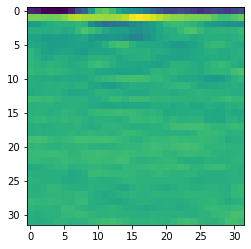

torch.Size([32, 32])
Label: 11


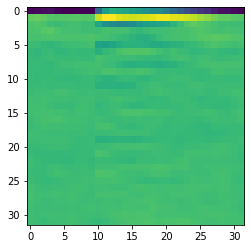

torch.Size([32, 32])
Label: 11


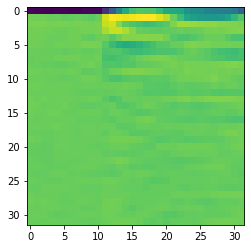

torch.Size([32, 32])
Label: 11


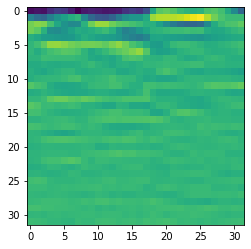

torch.Size([32, 32])
Label: 11


In [13]:
# Display image and label.
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(img.shape)
print(f"Label: {label}")

img = train_features[1].squeeze()
label = train_labels[1]
plt.imshow(img)
plt.show()
print(img.shape)
print(f"Label: {label}")

img = train_features[2].squeeze()
label = train_labels[3]
plt.imshow(img)
plt.show()
print(img.shape)
print(f"Label: {label}")

img = train_features[3].squeeze()
label = train_labels[3]
plt.imshow(img)
plt.show()
print(img.shape)
print(f"Label: {label}")
# grid = make_grid(train_features)
# show(grid)

**Trying to add new class parameters to the model: need tocheck how many nodes get added to analyse how much comutation would incease**

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Selected device is: {device}")
model = models.cnnModel()
pretrained_model_path = "./savedmodels/best_model_state.pt"
model.load_state_dict(copy.deepcopy(torch.load(pretrained_model_path, map_location='cpu')), strict=False)

#add new class parameters , here we have added 3 new classes
input_features = model.fc3.in_features
output_features = model.fc3.out_features
print(f"Pre-trained model input features: {input_features}")
print(f"Pre-trained model output features: {output_features}")

params = list(model.parameters())
print(f"Number of total parameters used in a network: {len(params)}")
print(f"Old model: {model}")

new_output_features = output_features + len(random_targets)
print(f"new output features: {new_output_features}")

model.fc3 = nn.Linear(in_features=input_features, out_features= new_output_features)
input_features = model.fc3.in_features
output_features = model.fc3.out_features
print(f"New model input features: {input_features}")
print(f"New model output features: {output_features}")

params = list(model.parameters())
print(f"Number of total parameters used in a network: {len(params)}")
print(f"New model; {model}")

Selected device is: cpu
Pre-trained model input features: 256
Pre-trained model output features: 11
Number of total parameters used in a network: 8
Old model: Net(
  (conv): Conv2d(1, 512, kernel_size=(16, 16), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=11, bias=True)
)
new output features: 14
New model input features: 256
New model output features: 14
Number of total parameters used in a network: 8
New model; Net(
  (conv): Conv2d(1, 512, kernel_size=(16, 16), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, 

In [15]:
conv1 = nn.Conv2d(1, 512, kernel_size=(16, 16), stride=(1, 1))
logits = F.leaky_relu(conv1(train_features))
print(f"Shape after conv layer 1: {logits.shape}")
pool = nn.MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
logits = pool(logits)
print(f"Shape after max_pool conv layer 1: {logits.shape}")
drop = nn.Dropout(p=0.25)
logits = drop(logits)
print(f"Shape after drop: {logits.shape}")
# print(f"shape of 1D converted logits to pass to Linear layer further: {torch.flatten(logits).shape}")
#
logits = logits.view(logits.size(0),-1)
# fc1 = nn.Linear(in_features=512*2*8, out_features=1024, bias=True). # in case of input([1, 32, 81])
fc1 = nn.Linear(in_features=2048, out_features=1024, bias=True)
logits  = F.leaky_relu(fc1(logits))
print(f"Shape after fc1: {logits.shape}")

fc2 = nn.Linear(in_features=1024, out_features=256, bias=True)
logits = drop(logits)
logits = F.leaky_relu(fc2(logits))
print(f"Shape after fc2: {logits.shape}")

fc3 = nn.Linear(in_features=256, out_features=14, bias=True)
logits = fc3(logits)
print(f"Shape after fc3: {logits.shape}")

#todo: change 11 to 10 classes for pre-trained model

Shape after conv layer 1: torch.Size([5, 512, 17, 17])
Shape after max_pool conv layer 1: torch.Size([5, 512, 2, 2])
Shape after drop: torch.Size([5, 512, 2, 2])
Shape after fc1: torch.Size([5, 1024])
Shape after fc2: torch.Size([5, 256])
Shape after fc3: torch.Size([5, 14])


**Cross Entropy loss and Distillation loss**:



In pytorch nn.crossEntropyLoss already applied softmax function:

nn.crossEntropyLoss = nn.LogSoftmax + nn.NLLLoss

therefore, no sofmax in last layer and y_actual should be one hot encoded and logits should be raw from linera layer

In [16]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
#lets try with creating functions from scratch
T = 1
def softmax(logits):
  return np.exp(logits/T)/np.sum(np.exp(logits/T), axis=0)

x = np.array([2.0, 1.0, 0.1])
y_pred = softmax(x)
print(f"softmax output with numpy: {y_pred}")

#in pytorch
x = torch.tensor([[2.0, 1.0, 0.1], [3.0, 1.0, 0.1]])
y_pred = torch.softmax(x/T, dim=0)
print(f"softmax output with pytorch: {y_pred}")

#3d tensor softmax
x = torch.tensor([[[2.0, 1.0, 0.1], [1.0, 1.0, 0.1]], [[2.0, 1.0, 0.1], [2.0, 1.0, 0.1]]])
print(f"shape of tensor {x.shape}")
y_pred = torch.softmax(x/T, dim=0)
print(f"softmax output with pytorch for 3D tensor in dim 0: {y_pred}")
y_pred = torch.softmax(x/T, dim=1)
print(f"softmax output with pytorch for 3D tensor in dim 1: {y_pred}")
y_pred = torch.softmax(x/T, dim=2)
print(f"softmax output with pytorch for 3D tensor in dim 2: {y_pred}")
#Cross entropy
def cross_entropy(actual, predicted):
  #predicted should be softmax of logits
  #actual should be one hot encoded
  loss = -np.sum(actual * np.log(predicted))
  return loss #not normalized

x = np.array([2.0, 1.0, 0.1])
y_actual = np.array([0, 1, 0])
loss = cross_entropy(y_actual, softmax(x))
print(f"cross entropy loss with numpy: {loss}")

#in pytorch
#x should be of size nsamples x nclasses (1x3)
x = torch.tensor([[2.0, 1.0, 0.1]])
y_actual = torch.tensor([1]) #no hot encoded , only pass index of the class
loss = nn.CrossEntropyLoss()
l = loss(x, y_actual)
print(f"cross entropy loss with pytorch: {l.item()}")


#Distillation loss
##temerature value decide how much weight should give to smaller propabilities
##hight T value higher weightage to smaller probabilities 
T = 2
y_pred = F.softmax(x/T, dim=1)
print(f"softmax output with pytorch functional: {y_pred}")


def knowledge_distillation_loss(old_logits, updated_logits, T):
  prob_old_logits = F.softmax(old_logits/T, dim=1)
  # print(prob_old_logits.shape)
  log_prob_updated_logits = F.softmax(updated_logits/T, dim=1)
  # print(log_prob_updated_logits.shape)
  dist_loss = - (prob_old_logits * log_prob_updated_logits).sum(dim=1)
  # print(dist_loss.shape)
  dist_loss = dist_loss.mean()
  return dist_loss

#e.g 3 classes --> 3 labels of tensor size([3])
old_logits = torch.rand(5,11)
updated_logits = torch.rand(5,11)
T = 1
kd_loss = knowledge_distillation_loss(old_logits, updated_logits, T)
print(f"Knowledge distillation: {kd_loss} ")

softmax output with numpy: [0.65900114 0.24243297 0.09856589]
softmax output with pytorch: tensor([[0.2689, 0.5000, 0.5000],
        [0.7311, 0.5000, 0.5000]])
shape of tensor torch.Size([2, 2, 3])
softmax output with pytorch for 3D tensor in dim 0: tensor([[[0.5000, 0.5000, 0.5000],
         [0.2689, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.7311, 0.5000, 0.5000]]])
softmax output with pytorch for 3D tensor in dim 1: tensor([[[0.7311, 0.5000, 0.5000],
         [0.2689, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]]])
softmax output with pytorch for 3D tensor in dim 2: tensor([[[0.6590, 0.2424, 0.0986],
         [0.4155, 0.4155, 0.1689]],

        [[0.6590, 0.2424, 0.0986],
         [0.6590, 0.2424, 0.0986]]])
cross entropy loss with numpy: 1.4170300162778335
cross entropy loss with pytorch: 1.4170299768447876
softmax output with pytorch functional: tensor([[0.5017, 0.3043, 0.1940]])
Knowledge distillation: -0.0894925743

In [ ]:
tensor1 = torch.rand(2,5)
tensor2 = torch.rand(2,5)
print(f"tensor1 : {tensor1}")
print(f"tensor1 : {tensor2}")
print(f"addition: {tensor1 + tensor2}")
tensor = torch.rand(2, 3, 4,5)
print(tensor)
tensor3 = torch.tensor([[[2.0, 1.0, 0.1], [2.0, 1.0, 0.1]] ,[[2.0, 1.0, 0.1], [2.0, 1.0, 0.1]]])
print(tensor3.shape)

tensor1 : tensor([[0.4121, 0.0814, 0.6294, 0.6830, 0.7091],
        [0.2044, 0.4821, 0.0080, 0.2398, 0.6811]])
tensor1 : tensor([[0.2781, 0.0638, 0.1684, 0.3694, 0.7510],
        [0.1884, 0.6669, 0.6748, 0.9250, 0.4021]])
addition: tensor([[0.6903, 0.1452, 0.7978, 1.0523, 1.4601],
        [0.3928, 1.1490, 0.6827, 1.1647, 1.0832]])
tensor([[[[0.9701, 0.6414, 0.0139, 0.3798, 0.2563],
          [0.0616, 0.7785, 0.3423, 0.2857, 0.6295],
          [0.9482, 0.2272, 0.9472, 0.0610, 0.4925],
          [0.9717, 0.2479, 0.0136, 0.9388, 0.4949]],

         [[0.0206, 0.6370, 0.0084, 0.0033, 0.1794],
          [0.0740, 0.2726, 0.1993, 0.0696, 0.7359],
          [0.5071, 0.7440, 0.4200, 0.1331, 0.7226],
          [0.8211, 0.2407, 0.9742, 0.3744, 0.3853]],

         [[0.1420, 0.6136, 0.3525, 0.2356, 0.8280],
          [0.4736, 0.7279, 0.9201, 0.7615, 0.9052],
          [0.2509, 0.4007, 0.6267, 0.0033, 0.7524],
          [0.8290, 0.1768, 0.5954, 0.9816, 0.9369]]],


        [[[0.9215, 0.9197, 0.5631, 

In [ ]:
x = torch.tensor([2.0, 1.0, 0.1])
print(x.shape)
x = torch.tensor([[2.0, 1.0, 0.1]])
print(x.shape)
x = torch.tensor([2])
print(x.shape)
x = torch.tensor([[2.0, 1.0, 0.1], [2.0, 1.0, 0.1]])
print(x.shape)

torch.Size([3])
torch.Size([1, 3])
torch.Size([1])
torch.Size([2, 3])


In [ ]:
class learningWithoutForgetting(object):
    def __init__(self, pretrained_model_path, optimizer = 'Adam', num_epochs = 10):
        self.num_epochs = num_epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # load model
        print("Loading the pre-trained model...")
        self.model = models.cnnModel()
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        self.model.load_state_dict(copy.deepcopy(torch.load(pretrained_model_path, map_location='cpu')), strict=False)
        # Loss function and optimizer
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)

    def evaluate_model(self, X_test, y_test):
        """ Evaluate the model's performance on the test set X_test and y_test

        Parameters:
        ----------
        X_test: torch tensor of MFCC
        y_test: torch tensor of labels

        Returns:
        -------
        accuracy: average accuracy of the model
        accuracies: array of accuracy for each class
        """
        accuracy = 0  # average accuracy of the model
        accuracies = np.zeros(10)  # accuracy for each class
        nb_occurences = np.zeros(10)  # to convert counts to accuracy

        with torch.no_grad():
            for i in range(len(X_test)):
                prediction = self.model.predict(X_test[i].unsqueeze(0).to(device=self.device, dtype=torch.float))
                label = (int)(y_test[i].to(device= self.device).item())
                if prediction == label:
                    accuracies[label] = accuracies[label] + 1
                    accuracy = accuracy + 1 
                nb_occurences[label] = nb_occurences[label] + 1

        accuracy = accuracy / len(X_test)
        accuracies = np.divide(accuracies, nb_occurences)

        return accuracy, accuracies

    def addNovelClassesToModel(self, noNovelClasses):
      #add new novel classes to pre-trained model
      #add new class parameters , here we have added 3 new classes
      input_features = self.model.fc3.in_features
      output_features = self.model.fc3.out_features
      print(f"Old model: {model}")

      new_output_features = output_features + noNovelClasses
      print(f"new output features: {new_output_features}")

      self.model.fc3 = nn.Linear(in_features=input_features, out_features= new_output_features)

      input_features = model.fc3.in_features
      output_features = model.fc3.out_features
      print(f"New model input features: {input_features}")
      print(f"New model output features: {output_features}")

      # params = list(model.parameters())
      # print(f"Number of total parameters used in a network: {len(params)}")
      print(f"New model; {model}")

      #initialize new weights with something ***


      pass 

      
    def train(self, train_loader):
        best_accuracy = 0.0
        print("Started adaptation of a model !")
        prev_model = copy.deepcopy(self.model)
        #todo : add novel classes to pre-trained model
        self.addNovelClassesToModel(noNovelClasses = len(random_targets))
        for epoch in range(self.num_epochs):
          for i, (inputs, labels) in enumerate(train_loader):          
            # input = input.unsqueeze(1).float().to(self.device)
            # label = label.unsqueeze(0).long().to(self.device)
            self.model.train()
            running_loss = 0.0
            self.optimizer.zero_grad()
            logits = self.model(inputs) #batch_size x 14
            loss_new = F.cross_entropy(logits, labels)
            #calculate old loss
            #todo: check no of in_features in liner layer, because we are passing new data here 
            old_logits = prev_model(inputs)
            loss_old = knowledge_distillation_loss(old_logits=old_logits, 
                                                   updated_logits=logits[:, :-3]) # updates logits of size batch_size x 11 (only old logits)
            total_loss = 1*loss_old + loss_new ##todo: what ablout regularization term?
            total_loss.backward()
            self.optimizer.step()

    def test(self, inputs, labels):
        self.accuracy, self.accuracies = self.evaluate_model(inputs, labels)
        return

In [ ]:
FILE_PATH = "./savedmodels/best_model_state.pt"
batch = torch.load(new_training_samples_path)
inputs = torch.cat(batch, dim=0)
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
labels = torch.tensor(digits)

# test for different outputs:
meta_dataloader = MetaAudioDataLoader(10, 0.2)
test_inputs, test_labels = meta_dataloader.get_test_samples(5)
# Analysis for Adam tranfer learning
tl_adam = learningWithoutForgetting(pretrained_model_path=FILE_PATH, num_epochs=2)
tl_adam.cl_train(inputs, labels)
tl_adam.test(test_inputs, test_labels)

print(tl_adam.accuracy)

/content/drive/MyDrive/Colab Notebooks/git_projects/AudioClassificationWithDeepLearningAnalysis/dataset/Meta_Dataloader.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  inputs = torch.tensor(inputs)


Loading the pre-trained model...
Started adaptation of a model !
0.1
